# Maximizing Post Performance on Facebook
## A Quick Data Analysis

## Strategy
Maximizing Facebook post performance can be of significant value to a business or alternative organization. Fortunately for us, Facebook makes accessible an API for page owners to evaluate the performance of their posts and provides numerous metrics for post-user engagement and for post visibility. My goal in the following analysis is to identify and create predictive features and develop a machine learning model to predict future post success. Since there are many metrics to investigate for each post, I will perform a brief analysis and identify one or two metrics that I think make the most sense from a business standpoint and are generally applicable to the widest available Facebook community (i.e. some metrics provide information on only a subset of user groups, such as people who have liked the page or reacted to the post via Facebook stories and other channels).

## The Data
* Format: JSON file that contains data on the content and performance of news posts on Facebook page over a one year period.
* Each line of the file is a JSON document corresponding to a single post. 

## Goal
* Develop a model to predict post performance for new posts a user may want to create for this Facebook page.  

## Further Reading
* https://developers.facebook.com/docs/graph-api/reference/v2.11/insights

## Import packages

In [1]:
# Data wrangling and plotting packages
import pandas as pd
import json
import jsonlines
import missingno as msn
import seaborn as sns
import numpy as np
from pandas import set_option
import re
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
rcParams['xtick.major.pad'] = 1
rcParams['ytick.major.pad'] = 1

#NLP
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords


# Sklearn
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

% matplotlib inline

/Users/PML/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/PML/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Extract data from JSON files

In [2]:
data = []

with jsonlines.open('posts.json') as reader:
    for obj in reader:
        data.append(obj)

## Inspect JSON file contents
* To get a sense for post data, I investigated both the keys and values objects in the available JSON files

In [3]:
data[0].keys()

[u'picture',
 u'description',
 u'name',
 u'caption',
 u'link',
 u'link_to_post',
 u'created_time',
 u'message',
 u'id',
 u'insights']

In [5]:
df_insights_inspection = pd.DataFrame(data[0]['insights']).T

#df_insights_inspection.description.unique # Herein hashed to make navigating notebook simpler.

## Additional information about these Facebook page and post metrics are available at: 

https://developers.facebook.com/docs/graph-api/reference/v2.11/insights

* Based on Facebooks API documentation, it looks like "post_consumptions_unique" might be a good metric to predict. This metric is the total number of unique views for a post, and likely the best proxy for how visible a post is. It also appears to be influenced by other user interactions with a post such as shares, comments, and likes (see Facebook’s documentation page), and so may the most generalized metric for how a post performs. Nonetheless, it would be wise to inspect other relevant metrics to see how well they align.
* Additionally, I anticipate that Facebook post 'likes' is a metric of potential interest and one that is perhaps the most widely interpretable to people not familiar with the Facebook API.

## Create function to extract features and post performance metrics

In [6]:
def fb_insights_extractor():
    
    # define a pandas dataframe with columns mapping the data we want to extract from the JSON files
    df = pd.DataFrame(columns = ['id',
                                'created_time',
                                'name', 
                                'caption',
                                'message',
                                'post_video',
                                'post_fan_reach',
                                'post_consumptions',
                                'post_consumptions_unique',
                                
                                'post_engaged_users',
                                'post_engaged_fan',
                                'post_impressions_unique',

                                'comments', 
                                'likes', 
                                'shares'])   
    
    # Iterate through each post's JSON file and extract information to add to the dataframe. 
    # This iterator could likely be refactored but to keep it explicit, it is in the format below
    for i in range(len(data)):
        
        if data[i].get('id') != None:
            df.loc[i,'id'] = data[i]['id']
            
        if data[i].get('created_time') != None:
             df.loc[i,'created_time'] = data[i]['created_time']
        
        
        if data[i].get('name') != None:
            df.loc[i,'name'] = data[i]['name']

  
        if data[i].get('caption') != None:
                df.loc[i,'caption'] = data[i]['caption']

        
        if data[i].get('message') != None:
            df.loc[i,'message'] = data[i]['message']
            
        if data[i]['insights']['post_video_length']['values'][0].get('value') != None:
            if data[i]['insights']['post_video_length']['values'][0].get('value') > 0:
                df.loc[i,'post_video']  = 1
            else:
                 df.loc[i,'post_video']  = 0

        if  data[i]['insights']['post_fan_reach']['values'][0].get('value'):
            df.loc[i,'post_fan_reach'] = data[i]['insights']['post_fan_reach']['values'][0].get('value')
        
        
        if  data[i]['insights']['post_consumptions']['values'][0].get('value'):
            df.loc[i,'post_consumptions'] = data[i]['insights']['post_consumptions']['values'][0]['value']
        
        if  data[i]['insights']['post_consumptions_unique']['values'][0].get('value'):
            df.loc[i,'post_consumptions_unique'] = data[i]['insights']['post_consumptions_unique']['values'][0].get('value')
           
        if  data[i]['insights']['post_engaged_users']['values'][0].get('value'):
            df.loc[i,'post_engaged_users'] = data[i]['insights']['post_engaged_users']['values'][0].get('value')
            
        if  data[i]['insights']['post_engaged_fan']['values'][0].get('value'):
            df.loc[i,'post_engaged_fan'] = data[i]['insights']['post_engaged_fan']['values'][0].get('value')
            
        if  data[i]['insights']['post_impressions_unique']['values'][0].get('value'):
            df.loc[i,'post_impressions_unique'] = data[i]['insights']['post_impressions_unique']['values'][0].get('value')
       
        if data[i]['insights']['post_stories_by_action_type']['values'][0]['value'].get('comment') != None:
            df.loc[i,'comments'] = data[i]['insights']['post_stories_by_action_type']['values'][0]['value']['comment']
        
        if data[i]['insights']['post_stories_by_action_type']['values'][0]['value'].get('like'):
            df.loc[i,'likes'] = data[i]['insights']['post_stories_by_action_type']['values'][0]['value']['like']
        
        
        if data[i]['insights']['post_stories_by_action_type']['values'][0]['value'].get('share'):
            df.loc[i,'shares'] = data[i]['insights']['post_stories_by_action_type']['values'][0]['value']['share']

    return df  

## Run function to extract JSON data

In [7]:
data_extract = fb_insights_extractor()

## As a backup, I will store this data in serialized file for easier future retrieval

In [8]:
#data_extract.to_pickle('data_extract.pkl')

In [9]:
df = pd.read_pickle('data_extract.pkl')

## Quick inspection of data

In [10]:
df.sample(5)

,id,created_time,name,caption,message,post_video,post_fan_reach,post_consumptions,post_consumptions_unique,post_engaged_users,post_engaged_fan,post_impressions_unique,comments,likes,shares
7105,114431401958534_779210605480607,2014-11-30T20:53:00+0000,Timeline Photos,NaN,Meet Ed! He and his 9 other furry pals are ava...,0,31344,2208,1601,1958,1576,35168,13,438,52
7743,114431401958534_765507943517540,2014-11-06T16:19:09+0000,A windy day on tap as a potent storm blows ashore,komonews.com,A potent storm has strengthened overnight is m...,0,27808,1358,1160,1408,1155,34528,81,276,124
1088,114431401958534_918337534901246,2015-08-04T22:49:27+0000,Man fires shots from boat; threatens to blow u...,www.komonews.com,BREAKING: The area around Lakebay Marina has b...,0,40975,2977,2113,2276,1749,49229,125,146,105
6475,114431401958534_794703097264691,2014-12-28T00:53:31+0000,Timeline Photos,NaN,Anyone catch tonight's sunset? KOMO photograph...,0,31168,976,702,1848,1438,38112,32,1302,115
7255,114431401958534_776054732462861,2014-11-24T22:05:33+0000,Break-in hurts Habitat for Humanity in Marysville,komonews.com,Habitat for Humanity is building homes for nee...,0,9844,367,290,338,296,10788,31,50,20


## I will quckly check data types since the JSON files contain both strings and numeric data

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8639 entries, 0 to 8638
Data columns (total 15 columns):
id                          8639 non-null object
created_time                8639 non-null object
name                        7381 non-null object
caption                     5314 non-null object
message                     8538 non-null object
post_video                  8639 non-null object
post_fan_reach              8636 non-null object
post_consumptions           8637 non-null object
post_consumptions_unique    8637 non-null object
post_engaged_users          8637 non-null object
post_engaged_fan            8637 non-null object
post_impressions_unique     8636 non-null object
comments                    8499 non-null object
likes                       8547 non-null object
shares                      8394 non-null object
dtypes: object(15)
memory usage: 1.1+ MB


## Interpretation:
It looks like everything is stored as a string object, which will be incompatible with downstream analysis. I will write a quick function to format numeric data.

In [12]:
def make_numeric():
    
    in_convert_list = df.columns[5:]
    
    for i in in_convert_list:
    
        df.loc[:,i] = pd.to_numeric(df.loc[:,i])

make_numeric()

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8639 entries, 0 to 8638
Data columns (total 15 columns):
id                          8639 non-null object
created_time                8639 non-null object
name                        7381 non-null object
caption                     5314 non-null object
message                     8538 non-null object
post_video                  8639 non-null int64
post_fan_reach              8636 non-null float64
post_consumptions           8637 non-null float64
post_consumptions_unique    8637 non-null float64
post_engaged_users          8637 non-null float64
post_engaged_fan            8637 non-null float64
post_impressions_unique     8636 non-null float64
comments                    8499 non-null float64
likes                       8547 non-null float64
shares                      8394 non-null float64
dtypes: float64(9), int64(1), object(5)
memory usage: 1.1+ MB


### Now our data is in the appropriate format :)

## Visualize missing values:
Missing values are always a key concern and need to be attended to early on. I will use the awesome missingo package to visualize how complete this data set is. *Note that while regions correspond to missing data values.

Missing Values by columns


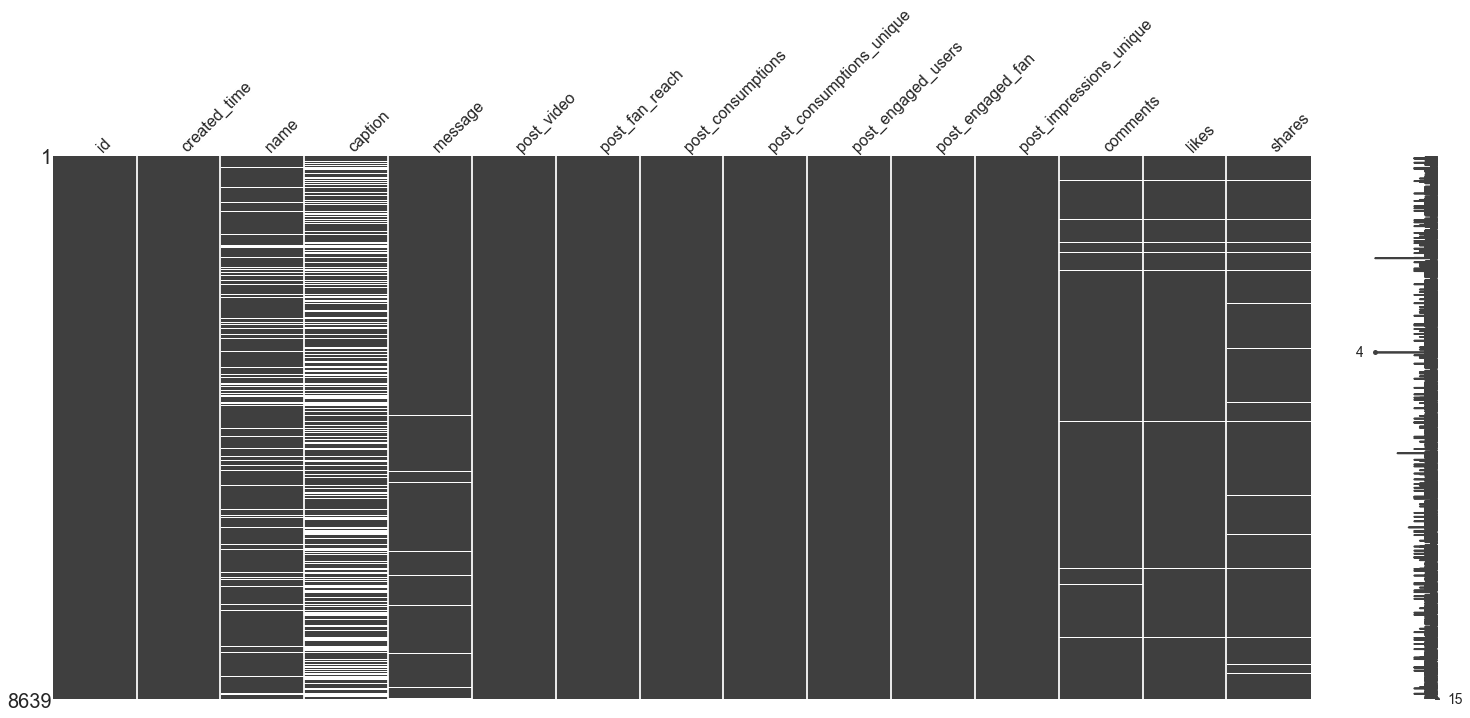

In [14]:
print('Missing Values by columns')
msn.matrix(df)

Missing Values by columns


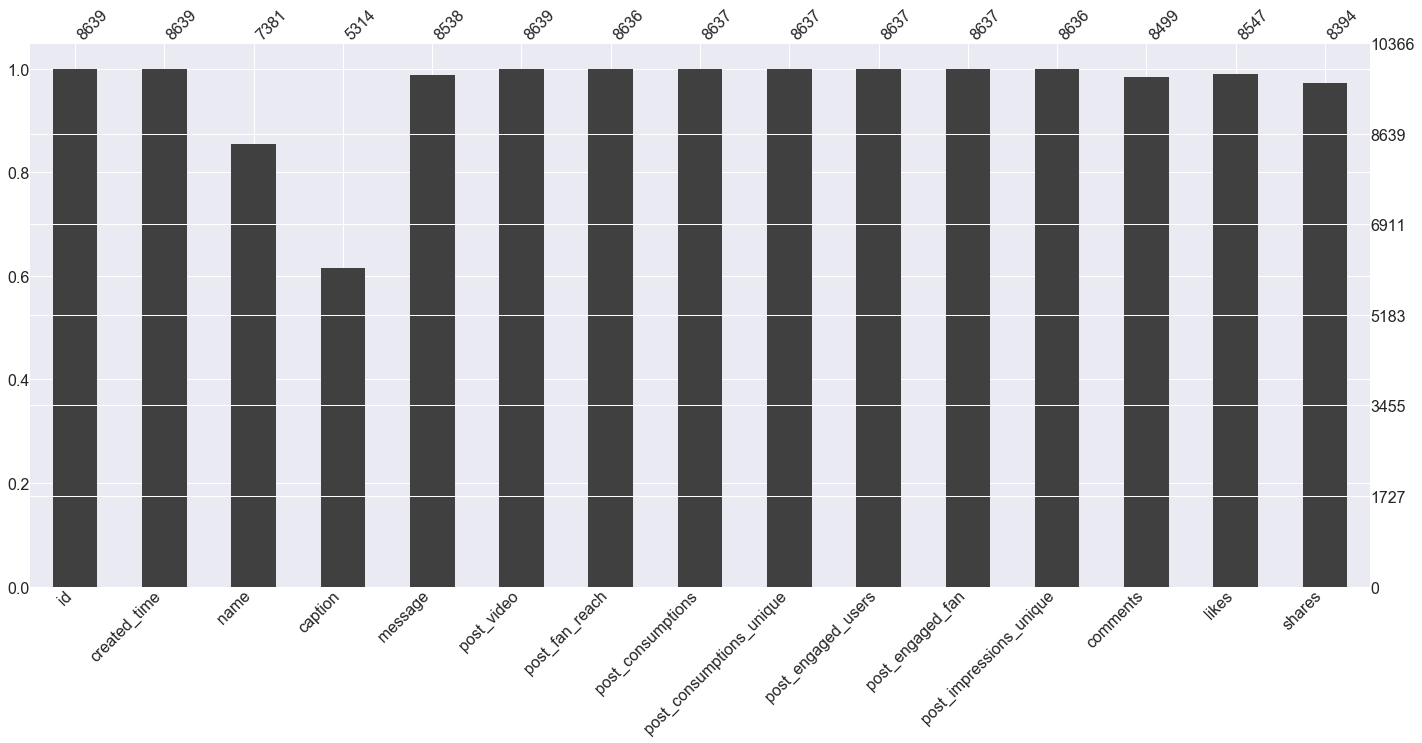

In [15]:
print('Missing Values by columns')
msn.bar(df)

## Intrepretation:
This data set is actually quite complete but there are still some values that are missing. For all numeric values, I will replace NaNs with zero. Here I am assuming that failure to collect these numeric featurs means that they were not present and should be represented as zero values. In other contexts, this assumption is open to question and might actually reflect issues in data collection.

## Filling missing Values

In [16]:
def fill_nans():
    
    nan_list = df.columns[5:]
    
    for i in nan_list:
        
        df.loc[:,i].fillna(0, inplace = True)
        
fill_nans()

### Missing Values in text data:
Next, I want to address missing values in the text data in a way that will signify that values are empty but is compatible with downstream language processing tools. For this I will simply fill NaNs with a label indicating that they were originally empty.

In [17]:
df.name = df.name.fillna('no_name')
df.caption = df.caption.fillna('no_caption')
df.message = df.message.fillna('no_message')

## Inspect correlation post performance metrics:
* There a many metrics to used to benchmark analysis of a post. To tackle this, I will check to see if certain metrics are highly correlated. If so, this may suggest that in many cases these metrics are mostly redundant and   would provide confidence that any particular metric should generalize to other post metrics. 

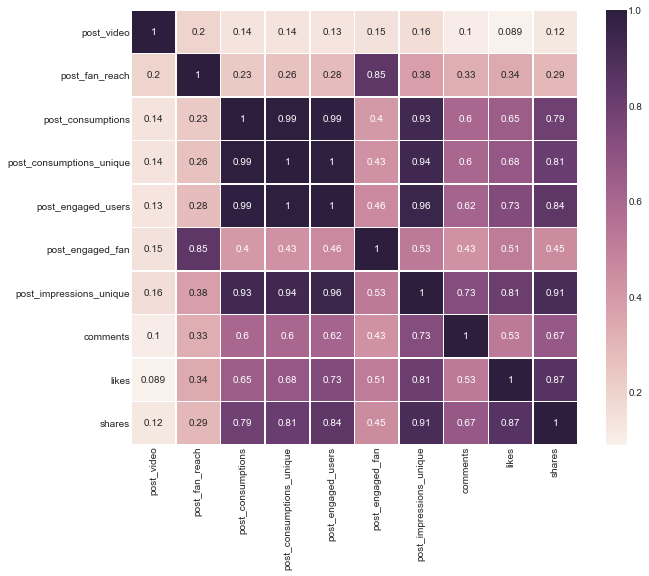

In [18]:
plt.figure(figsize=[10,8])
sns.heatmap(df.corr(), annot=True, linewidths=.5)

## Critical Analysis
* It looks like most of the metrics I pulled from post JSON files such as unique and total post consumption,  post_engaged_users, post_impression_unique, and shares are all highly correlated (i.e. ~80% and above). This gives me some confidence that maximizing 'post_consumption_unique' or post 'likes' should generalize to other metrics since performance on one may be predictive of performance on other metrics.

## Data Wrangling of text data
* The "caption" column could be important because it contains what news sites were posted. Certain sites are likely to be more popular than other. However, the text is a bit inconsistent and needs to attention. For example, 'www.cnn.com' and 'cnn.com' should be treated identically. I can use a quick string replace method to clean this up.

In [19]:
df.caption.unique()

array([u'komonews.com', 'no_caption', u'www.komonews.com',
       u'heartwalk.kintera.org', u'rumble.com', u'youtube.com',
       u'www.youtube.com', u'cnn.com', u'buzzfeed.com', u'abcnews.go.com',
       u'espn.go.com', u'www.upi.com', u'www.cnn.com', u'money.cnn.com',
       u'vimeo.com', u'cbcommunity.comcast.com', u'abc7news.com',
       u'www.outsideonline.com', u'pnsn.org', u'uwmedicinehealth.com',
       u'twitter.com', u'edition.cnn.com', u'storify.com',
       u'sbg.komonews.com', u'itv.com', u'youtu.be',
       u'politicallyoffbalance.com', u'abc7.com',
       u'giveto.seattlechildrens.org', u'us.movember.com',
       u'on.chideo.com', u'gismaps.kingcounty.gov', u'nws.noaa.gov',
       u'elections.komonews.com', u'aliexpress.com', u'tunein.com',
       u'crowdrise.com', u'becuautoeventnw.com'], dtype=object)

In [20]:
df.caption = df.caption.str.replace('^www.', '')

In [21]:
df.caption.unique()

array([u'komonews.com', 'no_caption', u'heartwalk.kintera.org',
       u'rumble.com', u'youtube.com', u'cnn.com', u'buzzfeed.com',
       u'abcnews.go.com', u'espn.go.com', u'upi.com', u'money.cnn.com',
       u'vimeo.com', u'cbcommunity.comcast.com', u'abc7news.com',
       u'outsideonline.com', u'pnsn.org', u'uwmedicinehealth.com',
       u'twitter.com', u'edition.cnn.com', u'storify.com',
       u'sbg.komonews.com', u'itv.com', u'youtu.be',
       u'politicallyoffbalance.com', u'abc7.com',
       u'giveto.seattlechildrens.org', u'us.movember.com',
       u'on.chideo.com', u'gismaps.kingcounty.gov', u'nws.noaa.gov',
       u'elections.komonews.com', u'aliexpress.com', u'tunein.com',
       u'crowdrise.com', u'becuautoeventnw.com'], dtype=object)

### There we go : )

## Feature engineer hour and day of week for each of post since these may be predictive 

In [22]:
df.created_time = pd.to_datetime(df.created_time)

df['hour'] = df.created_time.apply(lambda x: x.hour)
df['weekday'] = df.created_time.apply(lambda x: x.dayofweek)

## Brief Data Exploration
* All good model development requires good understanding of the data. This is a deep rabbit whole to go down, so I will focus on brevity while still seeking to better understand the data at hand.

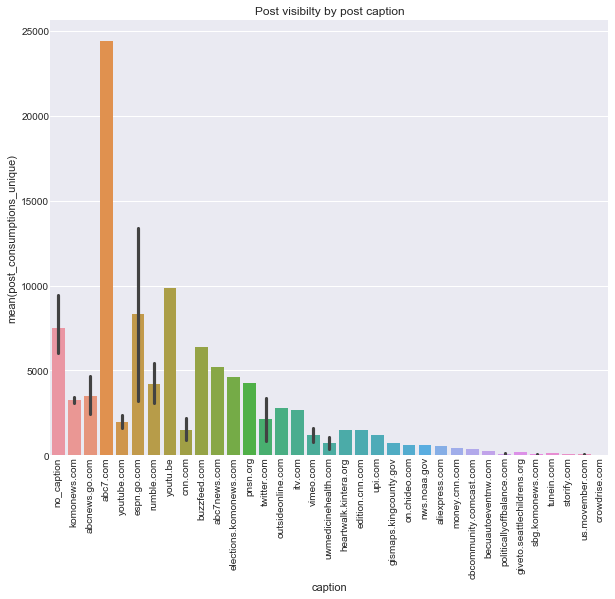

In [23]:
df_consumptions_unique_fig = df.loc[:,['caption', 'post_consumptions_unique']].sort_values('post_consumptions_unique',ascending = False )

plt.figure(figsize = [10,8])
plt.xticks(rotation = 90)
sns.barplot(y = 'post_consumptions_unique', x = 'caption', data = df_consumptions_unique_fig)
plt.title('Post visibilty by post caption')

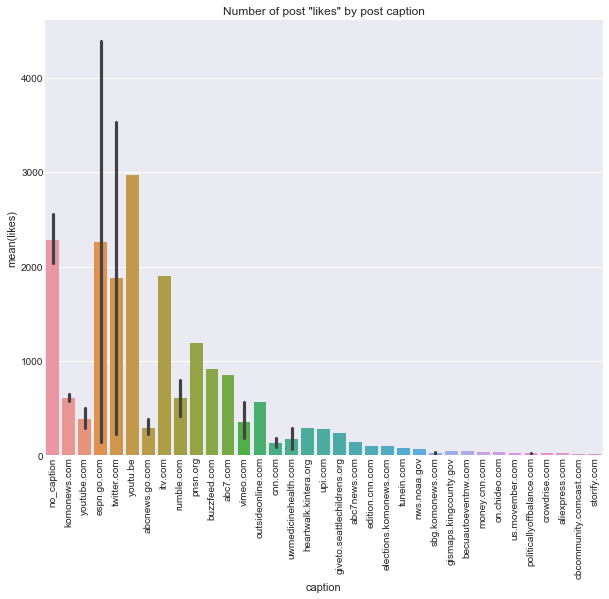

In [24]:
df_caption_fig = df.loc[:,['caption', 'likes']].sort_values('likes',ascending = False )

plt.figure(figsize = [10,8])
plt.xticks(rotation = 90)
sns.barplot(y = 'likes', x = 'caption', data = df_caption_fig)
plt.title('Number of post "likes" by post caption')

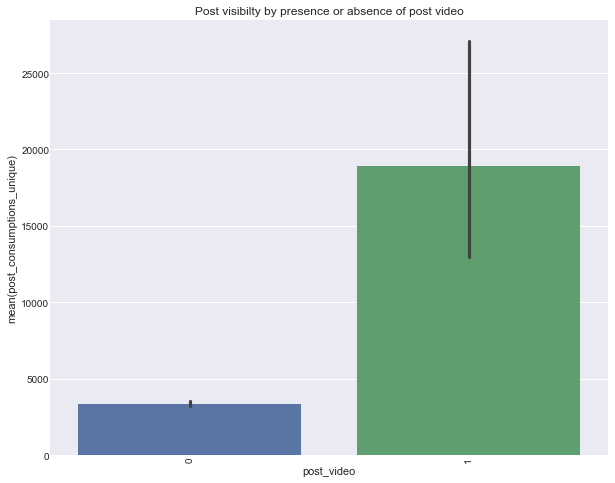

In [25]:
df_post_video_fig = df.loc[:,['post_video', 'post_consumptions_unique']].sort_values('post_video',ascending = False )

plt.figure(figsize = [10,8])
plt.xticks(rotation = 90)
sns.barplot(y = 'post_consumptions_unique', x = 'post_video', data = df_post_video_fig)
plt.title('Post visibilty by presence or absence of post video')

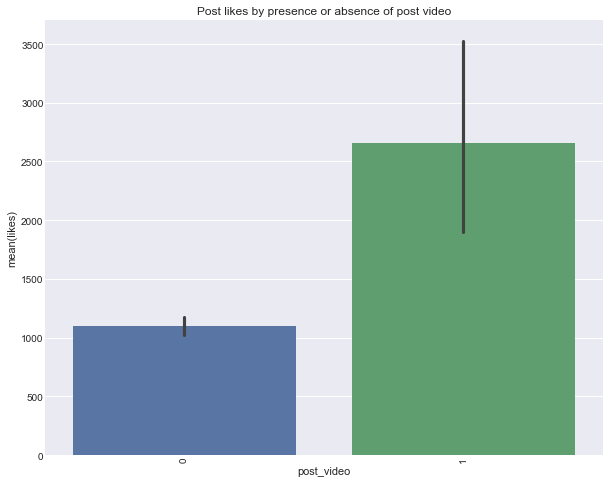

In [26]:
df_post_video_fig = df.loc[:,['post_video', 'likes']].sort_values('likes',ascending = False )

plt.figure(figsize = [10,8])
plt.xticks(rotation = 90)
sns.barplot(y = 'likes', x = 'post_video', data = df_post_video_fig)
plt.title('Post likes by presence or absence of post video')

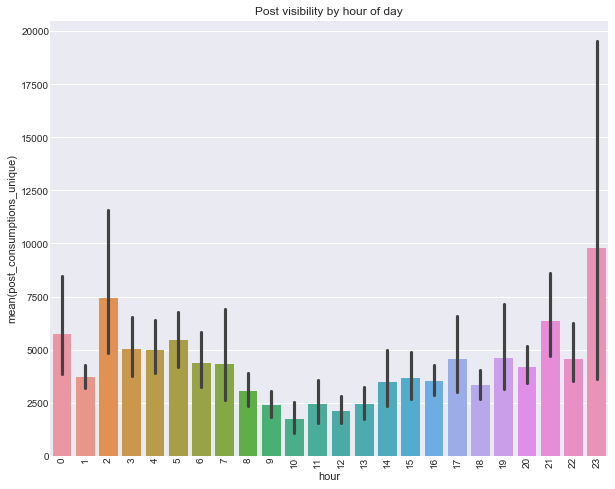

In [27]:
df_hour_fig = df.loc[:,['hour', 'post_consumptions_unique']].sort_values('post_consumptions_unique',ascending = False )

plt.figure(figsize = [10,8])
plt.xticks(rotation = 90)
sns.barplot(y = 'post_consumptions_unique', x = 'hour', data = df_hour_fig)
plt.title('Post visibility by hour of day')

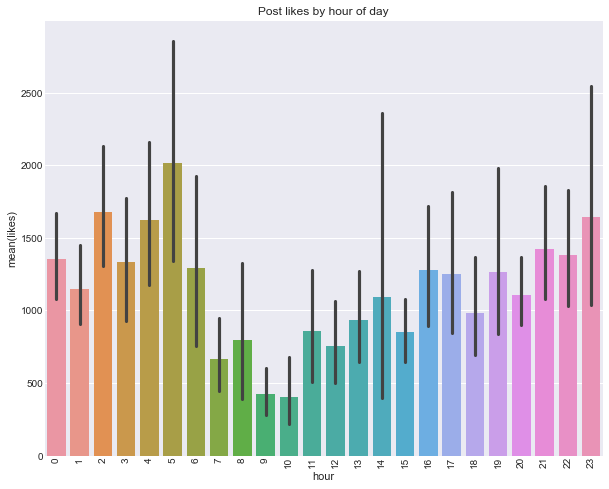

In [28]:
df_hour_fig = df.loc[:,['hour', 'likes']].sort_values('likes',ascending = False )

plt.figure(figsize = [10,8])
plt.xticks(rotation = 90)
sns.barplot(y = 'likes', x = 'hour', data = df_hour_fig)
plt.title('Post likes by hour of day')

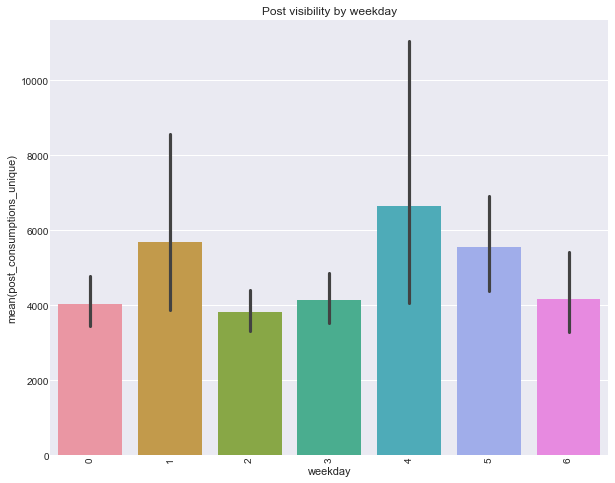

In [29]:
df_dayofweek_fig = df.loc[:,['weekday', 'post_consumptions_unique']].sort_values('post_consumptions_unique',ascending = False )

plt.figure(figsize = [10,8])
plt.xticks(rotation = 90)
sns.barplot(y = 'post_consumptions_unique', x = 'weekday', data = df_dayofweek_fig)
plt.title('Post visibility by weekday')

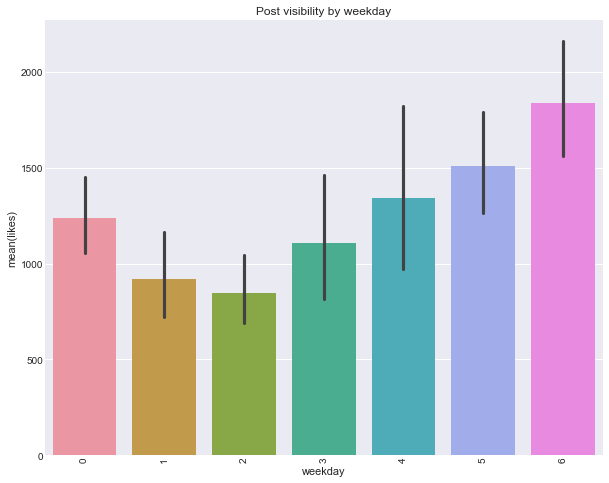

In [30]:
df_dayofweek_fig = df.loc[:,['weekday', 'likes']].sort_values('likes',ascending = False )

plt.figure(figsize = [10,8])
plt.xticks(rotation = 90)
sns.barplot(y = 'likes', x = 'weekday', data = df_dayofweek_fig)
plt.title('Post visibility by weekday')

## Intepretation:
* It looks like a few news sources tend to perform better both in terms of overall visibily and in number of likes.
* It also appears that posts with videos are much better at garnering visibily and likes. This is good to know.
* Post tend to peform better if posted early morning or later afternoon.
* While post visibility is relatively distributed across the week, posts submitted on later in the week and on weekends appear to garner more likes.

# Predicting Post Performance with Machine Learning



## Defining a target metric
* There are a lot of metrics that could be used to gauge post success, some of which will be media specific (i.e. do they contain a link, are they a video, is the target audience a user who has liked the webpage or is the target audience new users such as people who encounter and engage with the post vicariously by seeing it through people in their network etc.).
* Below I will assess 2 metrics: <b>total number of unique post views (i.e. impressions) and post likes</b>. 

## Predicting the number of 'unique post impressions' as a metric of post performance for supervised machine learning classification
* While I have numeric data that I can predict, which would suggest that this can be treated as a regression problem, this may not be the best appraoach. Predicting numeric output, such a total post likes, would require a lot of domain familiarity with how posts on this page historially perform and success could be more difficult to verify. By contrast, it may be more appropriate to make this a supervised learning classification problem. The primary reason for this is that it would <b>yield more actionable </b> results i.e. "Will future post perform well or not according to this model?" <br><br>
* To begin, I will try to predict whether a post will fall into the upper or lower 50th percentile unique post impressions for posts for this webpage. This metric is a proxy for the overall visibility/reach of a post and may be of signifance to a company aiming to maximize customer reach. 

## Identify the upper and lower 50th percentile cuttoff for unique post impressions

In [31]:
df.post_impressions_unique.describe()

count    8.639000e+03
mean     7.780620e+04
std      2.371642e+05
min      0.000000e+00
25%      2.691200e+04
50%      4.489800e+04
75%      7.771200e+04
max      1.282048e+07
Name: post_impressions_unique, dtype: float64

## Classify each post into upper or lower percentiles

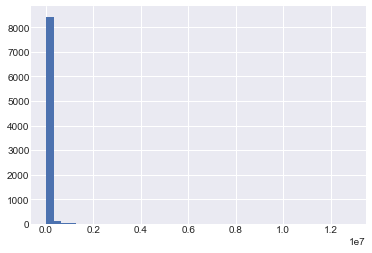

In [94]:
df.post_impressions_unique.hist(bins = 40)

In [100]:
df.post_impressions_unique.mode()

0    29184.0
1    31472.0
2    32704.0
3    34224.0
4    37312.0
5    41344.0
6    43056.0
7    56256.0
8    60032.0
9    62688.0
dtype: float64

In [95]:
df.post_impressions_unique.describe()

count    8.639000e+03
mean     7.780620e+04
std      2.371642e+05
min      0.000000e+00
25%      2.691200e+04
50%      4.489800e+04
75%      7.771200e+04
max      1.282048e+07
Name: post_impressions_unique, dtype: float64

In [113]:
df['post_impressions_unique_binned']= np.where(df['post_impressions_unique'] >= 44898, 1, 0)

## Feature engineering/NLP for text data


* I will use text data for post prediction. For this, I will ombine the text data from name, message, and caption columns. This will all be vectorized for each post.
* The following tool are used to convert text/string data into numeric features for machine learning. 
* I simplify text features, in this case words, via stemming using the porter stemmer method. This will help avoid treating similar words as unique and will help prevent an overly sparse matrix.
* I also perform some text preprocessing to capture emoticons, which could be relevant for a post's performance.
* I remove stop words using nltk stopwords dictionary. This will help identify relevent words for a post and eliminate less important ones.
* Finally, I use term frequency–inverse document frequency (tfidf) to reduce features and weight words based on their importance relative to other posts.

## Combine Text data into a single column

In [114]:
df['post_text'] = df.name + '' +  df.message + ''  + df.caption

## Split data into train and test sets

In [115]:
X_train_pcu, X_test_pcu, y_train_pcu, y_test_pcu = train_test_split(df.loc[:,['post_text', 'post_video', 'hour', 'weekday']], df['post_impressions_unique_binned'].values, test_size = .3, random_state =  42)

### Define pipeline for text processing

In [116]:
#""Pipeline for model using TFIDF for NLP""""

porter = PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split() ]

def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', 
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text


stop = stopwords.words('english')

tfidf = TfidfVectorizer(strip_accents='ascii',
                        lowercase=True,
                        preprocessor=preprocessor, 
                        tokenizer = tokenizer_porter,
                        stop_words = stop,
                        analyzer = 'word')

##  Fit and transform text data with vectorization and TFIDF
* Note: I want to process the text features separate from the video feature, hour and day of week. To Do this I will temporarily split my training and test input then concat them. This will allow me to do TFIDF and SVD only on text data. The precaution prevents the video data from by treated as a word, which could mask its significance.

In [117]:
X_train_pcu_info = X_train_pcu['post_text']
X_test_pcu_info= X_test_pcu['post_text']

X_train_pcu_info = tfidf.fit_transform(X_train_pcu_info)
X_test_pcu_info  = tfidf.transform(X_test_pcu_info)

## Look at matrix size

In [118]:
X_train_pcu_info[0]

<1x14704 sparse matrix of type '<type 'numpy.float64'>'
	with 26 stored elements in Compressed Sparse Row format>

## That matrix is large...

We can see in the cell above that we have a very sparse matrix....14694 columns! This is unwieldy. The dimensions can be reduced further.  Here I will use truncated Singular Value Decomposition (SVD), wherein I will need to choose the number of dimensions to reduce the matrix to. I can quickly assess if my dimension number is reasonable by looking at the explained_variance_ration after data fitting. 

## Reduce matrix size with truncatedSVD

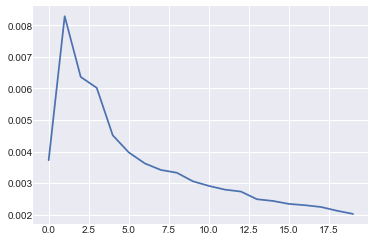

In [119]:
svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)  

X_train_pcu_info = svd.fit_transform(X_train_pcu_info)
X_test_pcu_info = svd.transform(X_test_pcu_info)

plt.plot(svd.explained_variance_ratio_)

## Interpretation:
* The gradual flattening of the slope near the right of this curve suggests that 20 features captures the majority of the variance in this data set.

## Now let's return the post video feature to the preprocessed text matrix
* The first 20 features are text data processed via TFIDf and SVD. the 21,22,and 23rd features will be binary indicator reflecting whether a post contains a video as well as the hour and day of week for a post.

In [120]:
X_train_pcu_formatted = pd.DataFrame(X_train_pcu_info)
X_test_pcu_formatted = pd.DataFrame(X_test_pcu_info)

X_train_pcu_formatted['post_video'] = np.array(X_train_pcu['post_video'])
X_train_pcu_formatted['hour'] = np.array(X_train_pcu['hour'])
X_train_pcu_formatted['weekday'] = np.array(X_train_pcu['weekday'])

X_test_pcu_formatted['post_video'] = np.array(X_test_pcu['post_video'])
X_test_pcu_formatted['hour'] = np.array(X_test_pcu['hour'])
X_test_pcu_formatted['weekday'] = np.array(X_test_pcu['weekday'])

## Quick glance at model input features

In [121]:
X_train_pcu_formatted.head(2)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,post_video,hour,weekday
0,0.047717,-0.036882,0.005719,-0.014406,-0.024421,-0.028011,-0.038629,-0.043899,0.021124,0.015510,...,-0.014348,0.002022,0.018737,-0.005574,-0.032632,0.029027,-0.039524,0,22,3
1,0.183761,-0.105512,0.008639,-0.034307,-0.061152,0.249148,0.037285,0.088120,-0.050423,0.032913,...,0.010378,-0.014358,0.133176,0.032640,0.027767,0.048810,-0.011389,1,22,4


# ML Algorithms Evaluation Pipeline
* This data set is sufficiently small that I have luxury of testing multiple shallow algorithms and evaluate optimal parameters.  Below I will build a pipeline to test 5 classification algorithms, peform gridsearch, and cross validation. Finally, I will compare their relative peformance with a focus on accuracy as my metric of interest.<br><br>

* Note: accuracy seems like an appropriate metric in this context. I am not exclusively concened with either the exactness (precision) or completeness (recall) for this models peformance. 

In [122]:
# Define parameters optimization with GridSearchCV.  

LR_params = {'C':[1, 10, 100]}
LDA_params = {'n_components':[None, 1,2,3],}
KNN_params = {'n_neighbors':[1,5,10,20], 'p':[2]}
RF_params = {'criterion':['gini'], 'n_estimators':[10,50,100,], 'max_depth':[10, 50, 100]}
DTC_params = {'criterion':['gini'], 'max_depth':[10, 50, 100]}

In [123]:
# Make list of models to test with paramter dictionaries.  

models_opt = []

models_opt.append(('LR', LogisticRegression(), LR_params))
models_opt.append(('LDA', LinearDiscriminantAnalysis(), LDA_params))
models_opt.append(('KNN', KNeighborsClassifier(),KNN_params))
models_opt.append(('DTC', DecisionTreeClassifier(), DTC_params))
models_opt.append(('RFC', RandomForestClassifier(), RF_params))

In [124]:
# Serially evaluate models with GridSearchCV using defined parameters and print performance as accuracies with SDs.

results_params = []
names_params = []
scoring = 'accuracy'

for name, model, params in models_opt:
    kfold= KFold(len(X_train_pcu_formatted), n_folds = 5, random_state=2, shuffle=True)
    model_grid = GridSearchCV(model, params)
    cv_results_params = cross_val_score(model_grid, X_train_pcu_formatted, y_train_pcu, cv=kfold, scoring=scoring)
    results_params.append(cv_results_params)
    names_params.append(name)
    msg = "CV Accuracy %s: %f (%f)" % (name, cv_results_params.mean(), cv_results_params.std())
    print(msg)

CV Accuracy LR: 0.653383 (0.002624)
CV Accuracy LDA: 0.655368 (0.004683)
CV Accuracy KNN: 0.579956 (0.007885)
CV Accuracy DTC: 0.634036 (0.009299)
CV Accuracy RFC: 0.664299 (0.010579)


In [ ]:
# Visualize model peformances.

fig = plt.figure(figsize=[8,5])

ax1 = fig.add_subplot(1,1,1)
ax1.boxplot(results_params)
ax1.set_ylim([0,1])
ax1.set_title('Model Performance')
ax1.set_ylabel('Accuracy')
ax1.set_xticklabels(names_params)
ax1.axhline(.5, color='r')
plt.xticks(rotation = 90)

## Interpretation:
* All of the models improve upon the baseline peformance of 50% (baselines because the classes are defined as upper and lower 50 percentiles and guessing each class 50% of the time should converge to this level of accuracy).
<br><br>
* I want to quickly test predictive perofrmance for one other post metric that is easily interpetable. In this case, the infamous facebook 'like'. I will divide post likes into upper and lower 50th percentile groups for classification.

# Let's apply machine learning to predict an additional post metric: Post 'Likes'
* The following pipeline will recycle the code above with the target label being upper and lower ranges for the number of facebook 'likes' a post recieves. 

In [52]:
df.likes.describe()

count      8639.000000
mean       1246.279546
std        5189.118347
min           0.000000
25%          88.000000
50%         234.000000
75%         755.500000
max      230001.000000
Name: likes, dtype: float64

In [53]:
df['performance_likes']= np.where(df['likes'] >= 234, 1, 0)

df['performance_likes'].value_counts()

1    4323
0    4316
Name: performance_likes, dtype: int64

## Split into train, test sets with new target variable then fit and transform with both TFIDF and truncated SVD

In [54]:
X_train_likes, X_test_likes, y_train_likes, y_test_likes = train_test_split(df.loc[:,['post_text', 'post_video', 'hour', 'weekday']], df['performance_likes'].values, test_size = .3, random_state =  42)


X_train_likes_info = X_train_likes['post_text']
X_test_likes_info= X_test_likes['post_text']

X_train_likes_info = tfidf.fit_transform(X_train_likes_info)
X_test_likes_info  = tfidf.transform(X_test_likes_info)

X_train_likes_info = svd.fit_transform(X_train_likes_info)
X_test_likes_info = svd.transform(X_test_likes_info)

X_train_likes_formatted = pd.DataFrame(X_train_likes_info)
X_test_likes_formatted = pd.DataFrame(X_test_likes_info)

X_train_likes_formatted['post_video'] = np.array(X_train_likes['post_video'])
X_train_likes_formatted['hour'] = np.array(X_train_likes['hour'])
X_train_likes_formatted['weekday'] = np.array(X_train_likes['weekday'])


X_test_likes_formatted['post_video'] = np.array(X_test_likes['post_video'])
X_test_likes_formatted['hour'] = np.array(X_test_likes['hour'])
X_test_likes_formatted['weekday'] = np.array(X_test_likes['weekday'])

## Test model perfomance

In [55]:
# Serially evaluate models with GridSearchCV using defined parameters and print performance as accuracies with SDs.

results_params = []
names_params = []
scoring = 'accuracy'

for name, model, params in models_opt:
    kfold= KFold(len(X_train_likes_formatted), n_folds = 5, random_state=2, shuffle=True)
    model_grid = GridSearchCV(model, params)
    cv_results_params = cross_val_score(model_grid, X_train_likes_formatted, y_train_likes, cv=kfold, scoring=scoring)
    results_params.append(cv_results_params)
    names_params.append(name)
    msg = "CV Accuracy %s: %f (%f)" % (name, cv_results_params.mean(), cv_results_params.std())
    print(msg)

CV Accuracy LR: 0.670085 (0.004806)
CV Accuracy LDA: 0.670744 (0.007000)
CV Accuracy KNN: 0.613690 (0.007401)
CV Accuracy DTC: 0.655034 (0.006262)
CV Accuracy RFC: 0.690092 (0.008503)


## Test XGBoost Classifier

In [57]:
from xgboost import XGBClassifier
import xgboost as xgb

xgb_model = xgb.XGBClassifier()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [1,6,10],
              'min_child_weight': [1,5,10],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [100], #number of trees, change it to 1000 for better results
              'seed': [42],
              'scale_pos_weight': [1],
             'reg_alpha':[1,5,10]}

# Run XGBoost to visualize feature importances


#xgb_model = xgb.train(parameters, dtrain = xgdmat, num_boost_round=100)

model = XGBClassifier()

clf = GridSearchCV(model, parameters, 
                   cv=5,
                   verbose=2, refit=True,
                   scoring='roc_auc')

clf.fit(X_train_likes_formatted, y_train_likes)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 
[CV]  reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 -   0.6s
[CV] reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 -   0.2s
[CV] reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 
[CV]  reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 -   0.3s
[CV] reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 
[CV]  reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=42, object

[CV]  reg_alpha=5, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=5, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 -   0.2s
[CV] reg_alpha=5, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=5, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 
[CV]  reg_alpha=5, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=5, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 -   0.2s
[CV] reg_alpha=5, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=5, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 
[CV]  reg_alpha=5, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=5, n_estimators=100, subsample=0.8, seed=42, object

[CV]  reg_alpha=10, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 -   0.2s
[CV] reg_alpha=10, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 
[CV]  reg_alpha=10, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 -   0.2s
[CV] reg_alpha=10, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=1 
[CV]  reg_alpha=10, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=

[CV]  reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=5, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=6 -   0.8s
[CV] reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=5, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=6 
[CV]  reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=5, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=6 -   0.7s
[CV] reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=5, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=6 
[CV]  reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=5, n_estimators=100, subsample=0.8, seed=42, object

[CV]  reg_alpha=5, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=6 -   1.2s
[CV] reg_alpha=5, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=6 
[CV]  reg_alpha=5, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=6 -   0.8s
[CV] reg_alpha=5, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=6 
[CV]  reg_alpha=5, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, o

[CV]  reg_alpha=10, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=10 -   1.5s
[CV] reg_alpha=10, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=10 
[CV]  reg_alpha=10, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=10 -   1.8s
[CV] reg_alpha=10, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=10 
[CV]  reg_alpha=10, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=1, n_estimators=100, subsample=0.8, seed=4

[CV]  reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=10 -   1.6s
[CV] reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=10 
[CV]  reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=10 -   1.6s
[CV] reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=42, objective=binary:logistic, max_depth=10 
[CV]  reg_alpha=1, colsample_bytree=0.7, silent=1, scale_pos_weight=1, learning_rate=0.05, nthread=4, min_child_weight=10, n_estimators=100, subsample=0.8, seed=4

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'reg_alpha': [1, 5, 10], 'scale_pos_weight': [1], 'learning_rate': [0.05], 'n_estimators': [100], 'seed': [42], 'colsample_bytree': [0.7], 'silent': [1], 'nthread': [4], 'min_child_weight': [1, 5, 10], 'subsample': [0.8], 'objective': ['binary:logistic'], 'max_depth': [1, 6, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=2)

In [58]:
#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

('Raw AUC score:', 0.7894040327692258)
colsample_bytree: 0.7
learning_rate: 0.05
max_depth: 10
min_child_weight: 5
n_estimators: 100
nthread: 4
objective: 'binary:logistic'
reg_alpha: 1
scale_pos_weight: 1
seed: 42
silent: 1
subsample: 0.8


In [59]:
xgb_model = XGBClassifier(colsample_bytree = 0.7,
                    learning_rate = 0.05,
                    max_depth = 10,
                    min_child_weight = 5,
                    n_estimators = 100,
                    nthread = 4,
                    objective = 'binary:logistic',
                    scale_pos_weight =1,
                    seed = 42,
                    silent = 1,
                    reg_alpha = 1,
                    subsample = 0.8
                     )

## Performance of XGboost

In [62]:
cv_results = cross_val_score(xgb_model, X_train_likes_formatted, y_train_likes, cv=kfold, scoring=scoring)
results_params.append(cv_results)
names_params.append(name)
msg = "CV %s: %f (%f)" % ('XGB', cv_results.mean(), cv_results.std())
print(msg)

CV XGB: 0.699355 (0.008345)


## Compare Model Performance

(array([1, 2, 3, 4, 5, 6]), <a list of 6 Text xticklabel objects>)

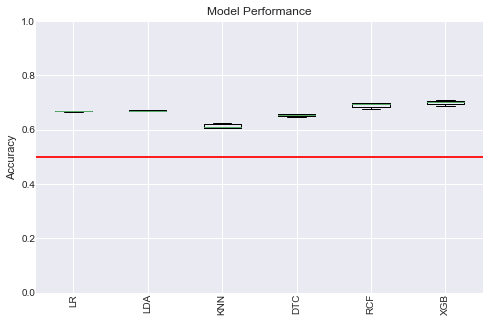

In [78]:
# Visualize model peformances.

fig = plt.figure(figsize=[8,5])

ax1 = fig.add_subplot(1,1,1)
ax1.boxplot(results_params)
ax1.set_ylim([0,1])
ax1.set_title('Model Performance')
ax1.set_ylabel('Accuracy')
ax1.set_xticklabels(names_params)
ax1.axhline(.5, color='r')
plt.xticks(rotation = 90)

## Interpretation: 
* These text vectors are slightly more effective at predicting the number of facebook likes. Since this might be more reflective of how well recieved a post is and perhaps a better proxy for the engagment and enthusiasm of a facebook user, we will proceed looking at facebook likes as a primary outcome one might want to optimize for future posts (note that this is still one of many options, and may in fact not be the best historical proxy to maximize user engagment).

# Select a winning model for final optimization and performance evaluation predicting post "Likes" 
* Since Random Forest was consistently the top performing algorithms, I will fit it on the entire training data, use grid search to confirm the best model parameters, then test it on the hold-out test data to predict post 'likes'.

In [79]:
rfc_model = RandomForestClassifier(random_state = 42)

rfc_model_params = {'criterion':['gini'], 'n_estimators':[10,50,100,], 'max_depth':[10, 50, 100]}

rfc_model_gs = GridSearchCV(rfc_model, rfc_model_params )

rfc_model_gs.fit(X_train_likes_formatted, y_train_likes)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100], 'criterion': ['gini'], 'max_depth': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

## Identify best model parameters

In [80]:
rfc_model_gs.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}

## Fit model using best parameters to entire training data then validate on test data

In [81]:
rfc_model = RandomForestClassifier(random_state = 42, criterion = 'gini', n_estimators = 50, max_depth = 10)

rfc_model.fit(X_train_likes_formatted, y_train_likes)

rcf_yhat = rfc_model.predict(X_test_likes_formatted)

## Model performance

In [82]:
print(classification_report(y_test_likes, rcf_yhat))
print('Model accuracy: {}'.format(accuracy_score(y_test_likes, rcf_yhat)))

             precision    recall  f1-score   support

          0       0.68      0.69      0.68      1306
          1       0.68      0.67      0.67      1286

avg / total       0.68      0.68      0.68      2592

Model accuracy: 0.679398148148


## Interpretation:
* This model performed about equally well with regard to precision, recall and accuracy at just under 70%, indicating that it is equally exact and complete. 

## Next, let's look at model performance across different probability thresholds by visualizing the AUC

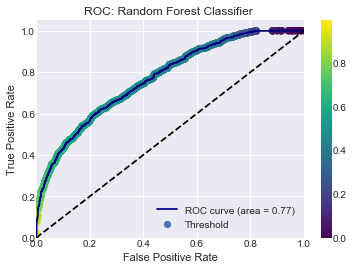

In [83]:
Y_prob = rfc_model.predict_proba(X_test_likes_formatted)

fpr, tpr, thresholds = roc_curve(y_test_likes, Y_prob[:,1])
roc_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, color='navy', label='ROC curve (area = %0.2f)' % roc_auc)
plt.scatter(fpr, tpr, c=thresholds, cmap='viridis', label='Threshold')
plt.colorbar()
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Random Forest Classifier ')
plt.legend(loc="lower right")
plt.show()

In [88]:
xgb_model.fit(X_train_likes_formatted, y_train_likes)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=10,
       min_child_weight=5, missing=None, n_estimators=100, nthread=4,
       objective='binary:logistic', reg_alpha=1, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=1, subsample=0.8)

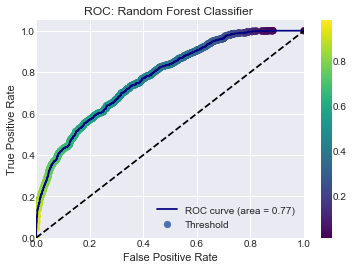

In [89]:
Y_prob = xgb_model.predict_proba(X_test_likes_formatted)

fpr, tpr, thresholds = roc_curve(y_test_likes, Y_prob[:,1])
roc_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, color='navy', label='ROC curve (area = %0.2f)' % roc_auc)
plt.scatter(fpr, tpr, c=thresholds, cmap='viridis', label='Threshold')
plt.colorbar()
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Random Forest Classifier ')
plt.legend(loc="lower right")
plt.show()

## Interpretation:
* The ROC plot reveals a 77% AUC, which indicates balance between true positive classification and false positive classification rates. For further model tuning, one has the option to select different model thresholds for classification; however, it looks like ~ 50% thershold performs near maximal. 

#  TAKE HOME AND KEY INSIGHTS


1. Highly viewed and liked posts tend to include select captions. * See data exploration <br><br>
2. Highly viewed and liked posts tend to include videos. * See data exploration<br><br>
3. An optimized random forest classifier is ~ 68-70% accurate in predicting whether a post will fall into the upper or lower 50th percentile of both unique post views (post consumption unique) or the number of Facebook 'likes' a post receives.  This model performed equally well in both precision and recall (~70%). This represents a 20% improvement over baseline predictions or 'random guess'.<br><br>
4. This model peformance can be acheived using text data collected from a post name, caption, and message along with information indicating whether a post contains a video, as well as the hour and weekday a post was submitted<br><br>
5. Text data can be prepared for modeling using text vectorization, TFIDF and truncated SVD, the latter of which provides a means of dimensional reduction. <br><br>
6. For improvements upon this model, further text analysis, such as topic modeling could be employed as an additional/alternative approach for feature engineering. Additionally, including information about a post's content, such as the inclusion of a link, image, etc. may confer greater predictive performance. Finally, it may be a good strategy to develop models that predict the performance of posts with different types of content, such as posts that include only text, or posts containing text alongside images, links, and/or videos, since each of these post types might be treated in a meaningfully different manner.<br><br>

### patrick.long@gmail.com